# Report Team 9: Sustainable water resources in the United States

## 1. Executive Summary

Today, the sustainable management of water resources is a key objective our team decided to tackle. In the meantime, water pollution and water consumption are two significant threats to this endeavor that we thought could be analyzed using the datasets available. Therefore, the issue around which our report is organized is the following:

#### Which economic factors are most predictive of high water pollution and water consumption levels?

We followed similar steps to identify predictive factors to the two variables of water consumption and water pollution and proceeded as follows:

#### I. Definition of the target variables: water pollution and water consumption levels
#### II. Visualizations on a map of the US territory
#### III. Core work on feature engineering and regression
#### IV. Conclusion

### Our main contributions:

- A sound water pollution index
- An analysis of water pollution trends in the United States
- Relevant economic feature sets to explain water consumption levels
- A rigourous investigation of the two target variables, that would benefit from an analysis using richer data and more sophisticated models.

## 2. Technical exposition

#### Modules Import

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import lightgbm as lgb
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import statsmodels.api as sm
tls.set_credentials_file(username='amaury.s', api_key='cxNz8wCOgQaMiGjiBN7k')

plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams['figure.figsize'] = (15.0, 10.0)

#### Datasets import

In [2]:
data_chemicals = pd.read_csv("chemicals.csv", encoding = "utf-8")
data_education = pd.read_csv("education_attainment.csv", encoding = "latin1")
data_industry_occupation = pd.read_csv("industry_occupation.csv", encoding="latin1")
data_industry_earnings = pd.read_csv("earnings.csv", encoding="latin1")

### 2.1 Analysis of water pollution

#### I. Water pollution definition

The definition of a proper water pollution metric proved challenging. First, we decided to focus on water pollution by chemicals: the only direct pollution measure available in the dataset, in the table **chemicals**:

In [3]:
data_chemicals.head()

,cws_name,chemical_species,contaminant_level,county,pws_id,pop_served,state,unit_measurement,value,year,fips,state_fips
0,CALIFORNIA WATER SERVICE - LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110003,57200,California,micrograms/L,1.54,2000,6001,6
1,CITY OF LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110011,26400,California,micrograms/L,1.64,2000,6001,6
2,CITY OF PLEASANTON,Uranium,Less than or equal MCL,Alameda,CA0110008,70600,California,micrograms/L,1.64,2000,6001,6
3,DUBLIN SAN RAMON SERVICES DISTRICT,Uranium,Less than or equal MCL,Alameda,CA0110009,72500,California,micrograms/L,1.64,2000,6001,6
4,NORRIS CANYON PROPERTY OWNERS ASSN,Uranium,Less than or equal MCL,Alameda,CA0103040,100,California,micrograms/L,4.51,2000,6001,6


- The geographical scale we retained is the **county**

The challenge is then to aggregate chemicals data in a sensible way at the county level. To do so, we chose the following **assumption and definition**:

- The **volume of water** consumed by human activities on a county's territory is assumed to be proportional to the total population of the county
- The **level of chemicals** spread in the volume of water distributed by a given water system **cws**, in a given county, is defined as the number $N$ of contaminants whose level in this water system is classified to 'greater_than_MCL'. This $N$ is then averaged on all the water systems in the county, with *weights* equal to the population supplied by each water system.

Given the above assumption on any county's water volume, the definition of a county's chemical level as a weighted averaged of contaminants in high concentrations is consistent, because the weights correspond to populations supplied by water systems and sum to the county's total population.

#### Data wrangling to obtain the chemicals_index:

In [4]:
data_chemicals['greater_than_MCL'] = (data_chemicals['contaminant_level'] == "Greater than MCL") * 1.
groups = data_chemicals.groupby(["year", "pws_id"])['pop_served', 'greater_than_MCL'].mean()
groups['greater_than_MCL'] *= data_chemicals.groupby(["year", "pws_id"])['greater_than_MCL'].count()
groups['index_weight'] = groups['pop_served'] * groups['greater_than_MCL']
final_groups = groups.groupby("year")['index_weight'].sum() / groups.groupby("year")['pop_served'].sum()

In [5]:
data_chemicals = data_chemicals[data_chemicals['year']==2010]
data_chemicals = data_chemicals.set_index(data_chemicals['fips'])
groups = data_chemicals.groupby("cws_name")[['greater_than_MCL', 'fips', "pop_served"]].mean()
groups['greater_than_MCL'] *= data_chemicals.groupby("cws_name")['greater_than_MCL'].count()
groups['index_with_weights'] = groups['greater_than_MCL']*groups['pop_served']
groups['fips'] = groups['fips'].astype(int)
chemicals_index = groups.groupby("fips")['index_with_weights'].sum() / groups.groupby("fips")['pop_served'].sum()

#### II. Visualization: countys with highest water pollution levels

In [6]:
eighty_quantile=chemicals_index.quantile(.75)
chemicals_index_eighty=chemicals_index[chemicals_index>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(chemicals_index_eighty.quantile(q))

fig = ff.create_choropleth(fips=chemicals_index_eighty.index.values, values=chemicals_index_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 75% polluted counties ")

C:\Users\User\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\User\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\plotly\figure_factory\_county_choropleth.py:771: UserWarning:

Unrecognized FIPS Values

Whoops! It looks like you are trying to pass at least one FIPS value that is not in our shapefile of FIPS and data for the counties. Your choropleth will still show up but these counties cannot be shown.
Unrecognized FIPS are: [19633, 28473, 31868, 32261, 37520, 37606, 37608, 40423, 42012]



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~amaury.s/0 or inside your plot.ly account where it is named 'Top 75% polluted counties '


This map shows the top 25% of counties with the highest water pollution levels. It seems that industrial states in the North-East and agricultural states in the center are most associated with high water pollution levels. Following this intuition, we tried to explain water pollution levels in any county by the relative share of each industry in those counties.

#### III. Features set 1: Industry shares in each county

First of all, we define the share of a given industry sector in a county as the percentage of the working population employed in this sector. More precisely:

$$ Industry\ share = 100 \times \frac{Population\ employed\ by\ industry}{Total\ working\ population\ in\ county}$$

**Hypothesis**: The shares of certain industry sectors is positively / negatively correlated with the pollution index.

*Remark: this approach does not differentiate between counties with large and small populations. This is roughly equivalent to assuming that a county's water reserves (which can be polluted by industries) are proportional to its population, which is a debatable assumption.*

Using a linear model, we build a predictive model of water pollution based on the industry share (both in 2010) of the following sectors:

- Agriculture
- Construction
- Manufacturing
- Wholesale trade
- Retail trade
- Transport and utilities
- Information
- Finance, insurance and real estate
- prof_scientific_waste
- Education and health
- Arts and entertainment
- Public administration
- Other

This leads to the following weights:

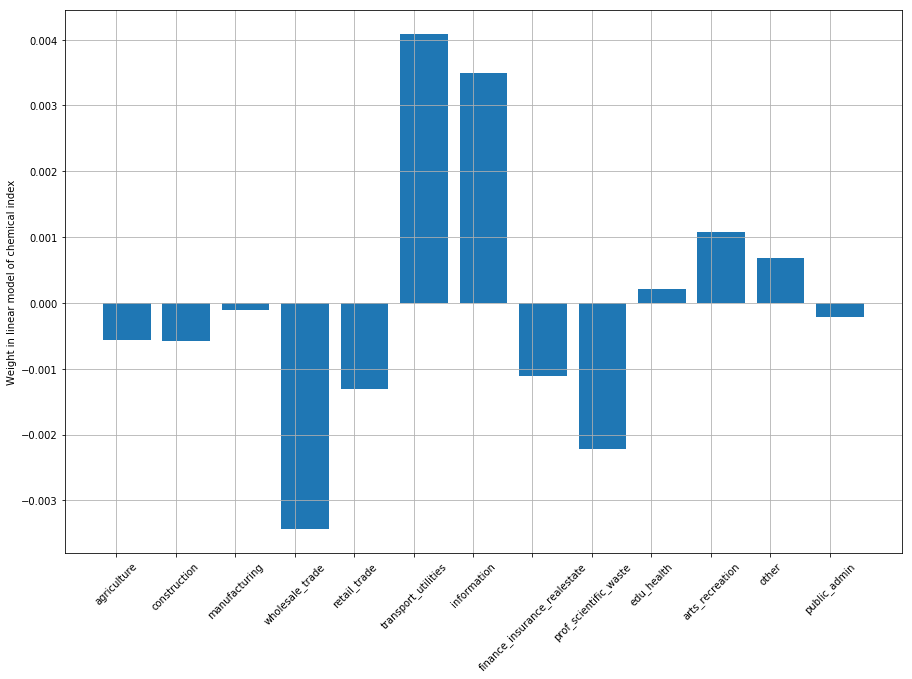

In [10]:
data_industry_earnings = data_industry_earnings[data_industry_earnings['year'] == 2010]
data_industry_occupation = data_industry_occupation[data_industry_occupation['year'] == 2010]

data_industry_occupation = data_industry_occupation.set_index(data_industry_occupation['fips'])
data_industry_earnings = data_industry_earnings.set_index(data_industry_earnings['fips'])

sectors_occupation = ['agriculture', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_utilities', 'information', 'finance_insurance_realestate', 'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other', 'public_admin']
industry_occ_pop = data_industry_occupation[sectors_occupation]
industry_occ_pop['chemicals'] = chemicals_index
industry_occ_pop['total_employed'] = data_industry_occupation['total_employed']
industry_occ_pop = industry_occ_pop.dropna()

for col in sectors_occupation:
    industry_occ_pop[col] = 100. * industry_occ_pop[col]/industry_occ_pop['total_employed']

X = industry_occ_pop[sectors_occupation]
Y = industry_occ_pop['chemicals']

L = Ridge()
L.fit(X, Y.values.reshape(-1,1))

ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(sectors_occupation)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight in linear model of chemical index")
plt.show()

#### Analysis of results

In [11]:
r2_score(Y.values.flatten(), L.predict(X))

0.02855000290596099

The above $R^{2}$ score is an *in sample* measure of the variance explained in the water pollution levels by our simple linear regression model: the model's performance is poor, and only 2.8% of the target variance is explained. Despite the difficulty of the target variable we examine, we can not infer much from this regression analysis.

#### III. Features set 2: Industry profitability

In this section, we investigate the link between the profitability of the various sectors and water pollution levels in U.S. counties. A good proxy for the profitability of an industry is the median revenue of the people it employs. To take account of the diversity of costs of living across the US, we instead consider these values relative to the median revenue in a given county (that is to say the profitability of a given sector w.r.t. the median revenue in the county). For a given sector, we then average these relative values across all counties in the US.

**Hypothesis**: the local profitability of some industries is positively or negatively correlated with the level of water pollution in a county.

We then fit a multivariate linear model to predict the level of water pollution given the county-level profitability of the following industry sectors:

- Agriculture, fishing and mining
- Construction
- Manufacturing
- Wholesale trade
- Retail trade
- Transport, warehouse and utilities
- Information
- Finance, insurance and real estate
- **total_prof_sci_mgmt_admin**
- Education, health and social
- Arts, entertainment and food
- Public administration
- Other services

We obtain the following weights for the various industries:

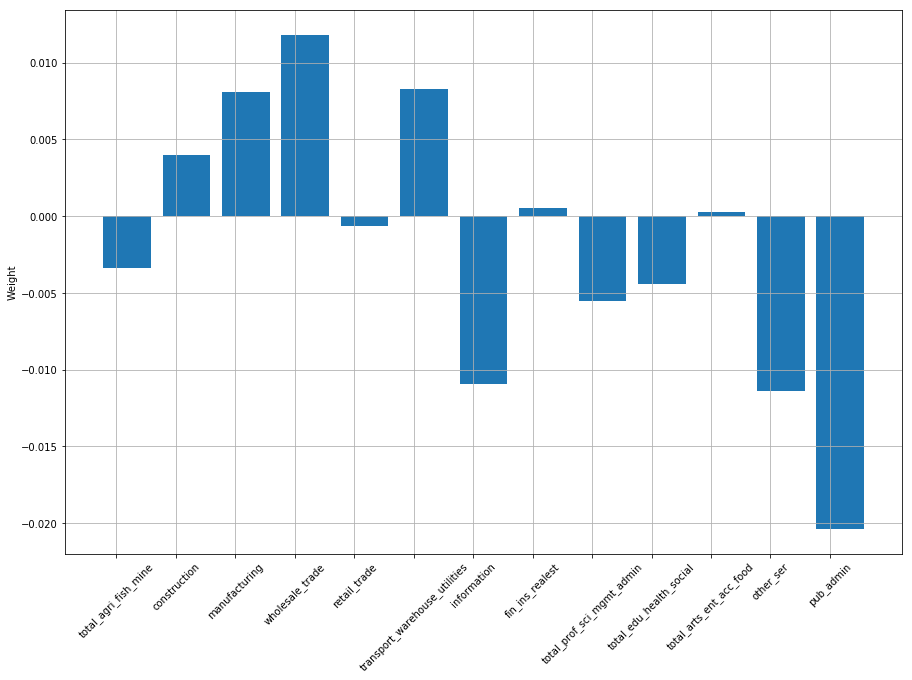

In [34]:
sectors_earnings = ['total_agri_fish_mine', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_warehouse_utilities', 'information', 'fin_ins_realest', 'total_prof_sci_mgmt_admin', 'total_edu_health_social', 'total_arts_ent_acc_food', 'other_ser', 'pub_admin']

for sector in sectors_earnings:
    if(data_industry_earnings[sector].dtype != float):
        data_industry_earnings[sector] = data_industry_earnings[sector].str.replace('-','')
        data_industry_earnings[sector] = data_industry_earnings[sector].str.replace('+','')
        data_industry_earnings[sector] = data_industry_earnings[sector].str.replace(',','')
        data_industry_earnings[sector] = data_industry_earnings[sector].astype(float)

industry_earnings = data_industry_earnings[sectors_earnings]
industry_earnings['chemicals'] = chemicals_index
industry_earnings['total_med'] = data_industry_earnings['total_med']

for sector in sectors_earnings:
    industry_earnings[sector] = (industry_earnings[sector] - industry_earnings['total_med']) / industry_earnings['total_med']
    industry_earnings[sector] = (industry_earnings[sector] - industry_earnings[sector].mean()) / industry_earnings[sector].std()

industry_earnings = industry_earnings.dropna()

X = industry_earnings[sectors_earnings]
Y = industry_earnings['chemicals']

L = Ridge()
L.fit(X.values, Y.values.reshape(-1,1))

ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(sectors_earnings)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.show()

In [35]:
r2_score(Y.values.flatten(), L.predict(X))

0.024673918994429278

Similarly, we can not infer much from such a score for our model.

#### IV. Conclusion

The above results look disappointing, the main contribution of our work in this past section is then the rigorous definition we produced of a water pollution index.

#### Afterthoughts

Based on the pollution index that we built and were satisfied with, we can build a nationwide water pollution index by simply computing the mean of the county-scale indices, weighted by each county's population. The value of the nationwide index is represented on the graph below, for the period 1999-2016:

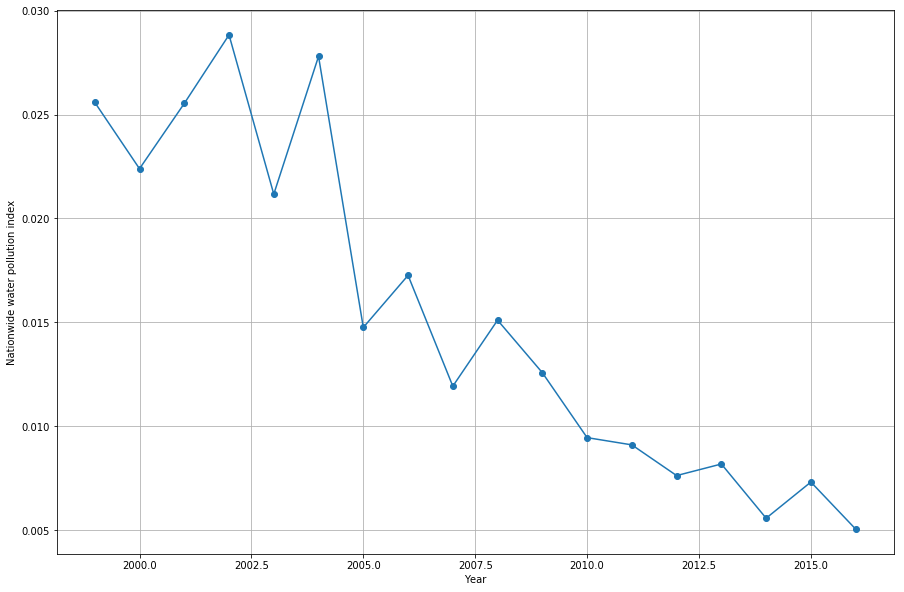

In [36]:
plt.plot(final_groups.index.values, final_groups.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Nationwide water pollution index")
plt.grid()

The trend seems clearly negative (which sounds like good news for our country's water reserves). To confirm this result, let us formulate the following hypothesis:

$$ H_1: Trend \neq 0 $$

and test it against:

$$ H_0: Trend = 0 $$

In [37]:
X = final_groups.index.values - 1999.
Y = final_groups.values

estimator = sm.OLS(Y, X.reshape(-1,1))
estimator = estimator.fit()

print("Linear regression p-value: {0}%".format(round(100*estimator.pvalues[0],2)))

Linear regression p-value: 1.7%


Fitting a linear model ($Pollution\ index = a \times (year-1999) + b$), we obtain a p-value of $1.7%$, clearly rejecting $H_0$ with a $95\%$ significance level.

We can then say with high confidence that the overall situation of the U.S. w.r.t. water pollution levels is improving, though it it is likely that it will remain critical in some areas for many years. There is hope about water pollution levels in the US and the trend seems favorable.

### 2.2 Analysis of water consumption

In [31]:
data_water = pd.read_csv("water_usage.csv")

#### I. Water consumption dataset

Water consumption data is available in the **water_usage** table

In [32]:
data_water.head()

,state,state_fips,county,county_fips,fips,year,population,pub_sup_1,pub_sup_2,pub_sup_3,...,thermoelectric_30,gro_wat_1,gro_wat_2,gro_wat_3,surf_wat_1,surf_wat_2,surf_wat_3,total_withdrawal_1,total_withdrawal_2,total_withdrawal_3
0,AL,1,Autauga County,1,1001,2010,54.571,NaN,NaN,48.222,...,6738.26,18.38,0.0,18.38,37.17,0.0,37.17,55.55,0.0,55.55
1,AL,1,Baldwin County,3,1003,2010,182.265,NaN,NaN,153.463,...,0.00,57.35,0.0,57.35,7.01,0.0,7.01,64.36,0.0,64.36
2,AL,1,Barbour County,5,1005,2010,27.457,NaN,NaN,25.555,...,0.00,6.71,0.0,6.71,4.34,0.0,4.34,11.05,0.0,11.05
3,AL,1,Bibb County,7,1007,2010,22.915,NaN,NaN,21.279,...,0.00,6.06,0.0,6.06,1.55,0.0,1.55,7.61,0.0,7.61
4,AL,1,Blount County,9,1009,2010,57.322,NaN,NaN,44.464,...,0.00,4.04,0.0,4.04,53.04,0.0,53.04,57.08,0.0,57.08


- We realized that we needed to cut down the number of columns, and to keep only the most relevant ones. We decided to retain the total water consumption for each water usage category. The number of columns dropped to TODO.
- Data was only available for the year 2010, we will limit the scope of our cross-dataset analysis to this year.

#### Data cleaning:

In [33]:
data_water = data_water.loc[data_water['year']==2010]
data_water = data_water.drop(['state','state_fips','county','county_fips','year'],axis=1)
for name in ['pub_sup','dom_sup','ind','irrigation','crop','golf','livestock','aqua','mining','thermoelectric','gro_wat','surf_wat','total']:
    cols_name = [n for n in data_water.columns if n.startswith(name)]
    cols_name.sort(key=lambda n : int(n.split('_')[-1]))
    col_kept = cols_name[-1]
    
    data_water['_'.join(col_kept.split('_')[:-1])] = data_water[col_kept]
    data_water = data_water.drop(cols_name,axis=1)
    
data_water = data_water.set_index('fips')

#### II. Visualization: countys with highest water consumption levels

In [18]:
total_water = data_water['total_withdrawal']

eighty_quantile=total_water.quantile(.75)
total_water_eighty=total_water[total_water>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(total_water_eighty.quantile(q))

fig = ff.create_choropleth(fips=total_water_eighty.index.values, values=total_water_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 25% water consumption counties ")

C:\Users\User\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




The above map shows the top 25% counties with the highest water consumption level. We immediately notice a strong difference between Eastern and Western states. Most of the counties with the highest water consumption levels are located in the West. We suspected this discrepancy to be linked to more frequent droughts in these regions of the United States. Let us visualize droughts in 2010 on a map:

In [20]:
data_drought = pd.read_csv("droughts.csv")

data_drought=data_drought[data_drought['valid_start'].str.startswith('2010')]

data_drought['valid_start'] = pd.to_datetime(data_drought['valid_start'])
data_drought['valid_end'] = pd.to_datetime(data_drought['valid_end'])
data_drought['event_duration_in_days'] = (data_drought['valid_end'] - data_drought['valid_start']).dt.days
data_drought['event_importance_with_weight'] = data_drought['event_duration_in_days'] * 0. + (data_drought['d0']*1. + data_drought['d1']*2. + data_drought['d2']*3. + data_drought['d3']*4. + data_drought['d4']*5.) / 100.
groups = data_drought.groupby("fips")
drought_index = groups['event_importance_with_weight'].sum() / groups['event_duration_in_days'].sum()



eighty_quantile=drought_index.quantile(.75)
drought_index_eighty=drought_index[drought_index>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(drought_index_eighty.quantile(q))

fig = ff.create_choropleth(fips=drought_index_eighty.index.values, values=drought_index_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 25% drought-stricken counties ")

The above map uses a local drought severity index that we designed using the following method:

- The U.S. Drought Monitor classifies drought events by severity, defining 5 levels of severity (from abnormally dry (D0) to exceptional drought (D4)). For each event (denoted by a start and end date), it measures the proportion of the county's population affected by each level (including a None level, which denotes a normal situation). We assign the score 0 to the level None, and scores from 1 to 5 for levels D0 to D4.
- For each event, we compute its score by calculating the mean of each level weighted by the population it affects.
- We then average these scores across a period of time, weighted by the duration of each event.

This gives us a value in $[0,5]$.

The above map, which we built for the year 2010, demonstrates results quite different from those obtained for water consumption.

However, 2010 was not really representative of the recurrent droughts that took place in the US. The following map shows the same drought index averaged on the 2010-2016. The results are much more robust, and very correlated to those obtained for water consumption:


In [21]:
data_drought = pd.read_csv("droughts.csv")

data_drought['valid_start'] = pd.to_datetime(data_drought['valid_start'])
data_drought['valid_end'] = pd.to_datetime(data_drought['valid_end'])
data_drought['event_duration_in_days'] = (data_drought['valid_end'] - data_drought['valid_start']).dt.days
data_drought['event_importance_with_weight'] = data_drought['event_duration_in_days'] * 0. + (data_drought['d0']*1. + data_drought['d1']*2. + data_drought['d2']*3. + data_drought['d3']*4. + data_drought['d4']*5.) / 100.
groups = data_drought.groupby("fips")
drought_index = groups['event_importance_with_weight'].sum() / groups['event_duration_in_days'].sum()



eighty_quantile=drought_index.quantile(.75)
drought_index_eighty=drought_index[drought_index>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(drought_index_eighty.quantile(q))

fig = ff.create_choropleth(fips=drought_index_eighty.index.values, values=drought_index_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 25% drought-stricken counties ")

#### III. Features set 0: Water usage / Industry shares correlation 

To begin our analysis, we drew the correlation matrix between the water consumption broke down by water usage and the industry workforce share of counties. We masked low correlation results for the sake of interpretability. As we could expect, we observe a high correlation  between the agriculture share and crop/irrigation water usages.

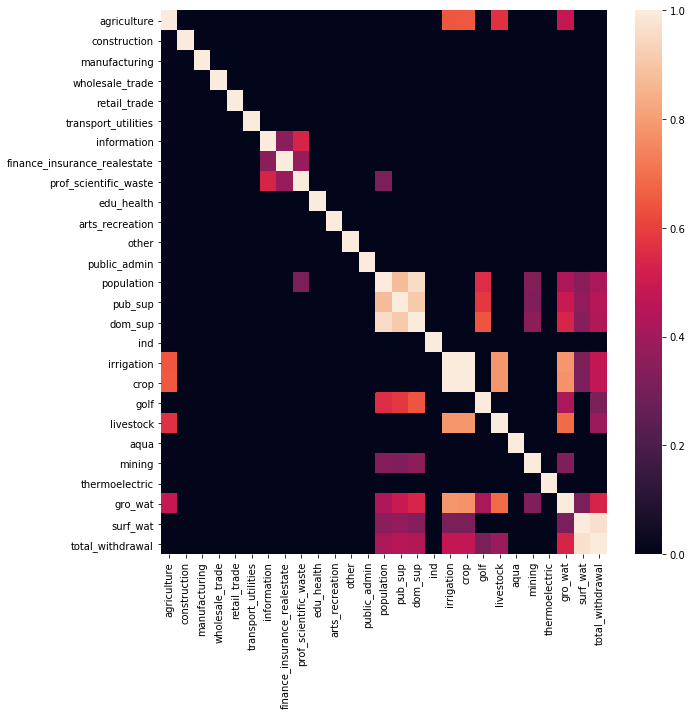

In [22]:
data_industry_occupation = pd.read_csv("industry_occupation.csv", encoding="latin1")
data_industry_occupation = data_industry_occupation[data_industry_occupation['year'] == 2010]
data_industry_occupation = data_industry_occupation.set_index(data_industry_occupation['fips'])


sectors_occupation = ['agriculture', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_utilities', 'information', 'finance_insurance_realestate', 'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other', 'public_admin']
industry_occ_pop = data_industry_occupation[sectors_occupation]
industry_occ_pop['total_employed'] = data_industry_occupation['total_employed']
industry_occ_pop = industry_occ_pop.dropna()

for col in sectors_occupation:
    industry_occ_pop[col] = 100. * industry_occ_pop[col]/industry_occ_pop['total_employed']

occupation_joined_consumption = industry_occ_pop[sectors_occupation].join(data_water,how='inner')
occupation_joined_consumption = occupation_joined_consumption.dropna()


# calculate the correlation matrix
corr = occupation_joined_consumption.corr()
corr[corr<.3]=0

# plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=occupation_joined_consumption.columns,
        yticklabels=occupation_joined_consumption.columns)
plt.show()

#### III. Features set 1: Industry shares

Correlations like the one between the share of agriculture in a county's workforce and high water consumption for irrigation and crops spurred us to reuse consider industry workforce shares in a county as a relevant feature set for water consumption.

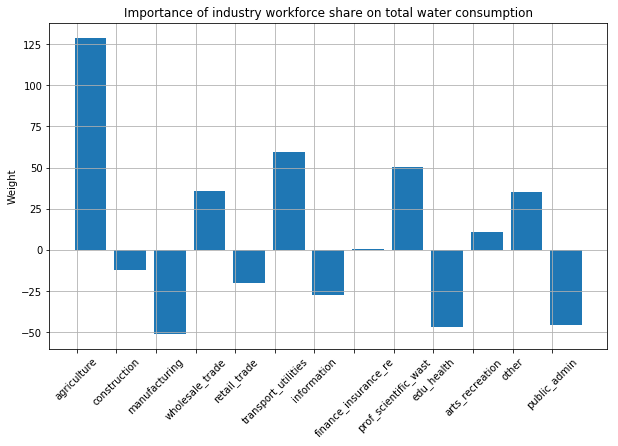

In [26]:
X=occupation_joined_consumption[sectors_occupation]
Y= occupation_joined_consumption['total_withdrawal']
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

L = Ridge(alpha=1e-3)
L.fit(X, Y.values.reshape(-1,1))
ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind)
ax.set_xticklabels([x[:20] for x in sectors_occupation])
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.title("Importance of industry workforce share on total water consumption")
plt.show()

#### Analysis of results

In [27]:
r2_score(Y.values.flatten(), L.predict(X))

0.11487477649726441

The $R^{2}$ score obtained is about three times as high as the one obtained for water pollution levels. Given the limited amount of data available, and water comsumption being a complex target, we are satisfied with this result and extract the following insights:

- As expected, agriculture is associated with higher water consumption levels
- A more 'bureaucatric' economy (important public sector, education sector, healthcare sector) correlates with lower water consumption levels

#### III. Features set 2: Industry profitability

Driven by the previous interesting insights, we decided to look as well as the feature set of industry profitability.

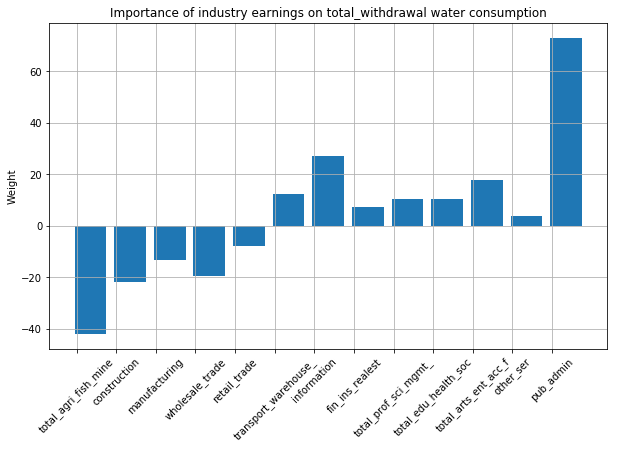

In [28]:
water_column='total_withdrawal'

joined_water_earnings=data_water.join(industry_earnings,how='inner')
joined_water_earnings = joined_water_earnings.dropna()
X= joined_water_earnings[sectors_earnings]
Y=joined_water_earnings[water_column]

X = StandardScaler().fit_transform(X)
L = Ridge(alpha=1e-2)
L.fit(X, Y.values.reshape(-1,1))
ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind)
ax.set_xticklabels([x[:20] for x in sectors_earnings])
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.title("Importance of industry earnings on {0} water consumption".format(water_column))
plt.show()

In [29]:
r2_score(Y.values.flatten(), L.predict(X))

0.08303028446614924

#### Analysis of results
The $R^{2}$ score is lower, but still more than two times as high as in the water pollution analysis. We derive the following interesting insights:

- When the agriculture sector is more profitable (perhaps thanks to modernized techniques, lower usage of water improving the profitability), water consumption levels tend to be lower.
- However, a more profitable (and perhaps more efficient) public sector does not correlate with lower water consumption levels. Indeed, while water prices should influence profitability in the agriculture sector, it is not the case for public administration.

#### IV. Conclusion

Results in this section are much more satisfying. The water consumption was easier to define and our feature sets proved predictive and insightful.